<hr>
<center><h2>Image Analysis</h2></center>
<hr>

## 1. Loading the data


Importing all necessaray packages, loading the dataand creating session

In [1]:
import torch
from PIL import Image
import io
import pandas as pd
import json
import random
import matplotlib as plt

In [2]:
import torchvision.transforms as transforms
from torchvision import models

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import cast, lit

Creating spark session

In [4]:
spark = SparkSession.builder \
    .appName("ImageNetClassification") \
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/22 21:18:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/22 21:18:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## 2. Using the ResNet model for classification

In [5]:
model = models.resnet50(pretrained=True)
model.eval()

/Users/prabhatks/miniconda3/envs/image_caption/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/prabhatks/miniconda3/envs/image_caption/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
with open("../utils/imageNet_weights.json") as f:
    labels = json.load(f)

In [8]:
# creating windows for classifying images in that window 
def split_image(image, patch_size):
    width, height = image.size
    patches = []
    for i in range(0, width, patch_size):
        for j in range(0, height, patch_size):
            box = (i, j, i + patch_size, j + patch_size)
            patch = image.crop(box)
            patches.append(patch)
    return patches

In [9]:
def classify_image(image_path, patch_size=224):
    image = Image.open(image_path)
    patches = split_image(image, patch_size)
    results = []
    for patch in patches:
        patch = preprocess(patch)
        patch = patch.unsqueeze(0)

        with torch.no_grad():
            outputs = model(patch)
        _, predicted = outputs.max(1)
        label = labels[predicted.item()]
        if label not in results:
            results.append(label)
    return results

In [10]:
classify_image_udf = udf(classify_image, StringType())

In [11]:
caption_df = spark.read.csv("../archive/captions.txt", header=True)
caption_df.show(5, truncate=False)

+-------------------------+------------------------------------------------------------------------+
|image                    |caption                                                                 |
+-------------------------+------------------------------------------------------------------------+
|1000268201_693b08cb0e.jpg|A child in a pink dress is climbing up a set of stairs in an entry way .|
|1000268201_693b08cb0e.jpg|A girl going into a wooden building .                                   |
|1000268201_693b08cb0e.jpg|A little girl climbing into a wooden playhouse .                        |
|1000268201_693b08cb0e.jpg|A little girl climbing the stairs to her playhouse .                    |
|1000268201_693b08cb0e.jpg|A little girl in a pink dress going into a wooden cabin .               |
+-------------------------+------------------------------------------------------------------------+
only showing top 5 rows



In [12]:
df_sampled = caption_df.sample(fraction=0.1, seed=random.randint(0,100))
df_sampled.show()

+--------------------+--------------------+
|               image|             caption|
+--------------------+--------------------+
|1001773457_577c3a...|A black dog and a...|
|1003163366_44323f...|A man lays on the...|
|1003163366_44323f...|A shirtless man l...|
|101654506_8eb26cf...|A brown and white...|
|101669240_b2d3e7f...|A skier looks at ...|
|1016887272_03199f...|Seven climbers ar...|
|1019077836_6fc9b1...|a brown dog plays...|
|1019604187_d087bf...|A white dog is ab...|
|1020651753_06077e...|The white dog is ...|
|1022454428_b6b660...|A man and woman c...|
|1022975728_755152...|A black dog runni...|
|1024138940_f1fefb...|Two dogs playing ...|
|102455176_5f8ead6...|A man uses ice pi...|
|102455176_5f8ead6...|an ice climber in...|
|102455176_5f8ead6...|Climber climbing ...|
|1030985833_b0902e...|A brown and black...|
|103106960_e8a41d6...|A young male knee...|
|103205630_682ca72...|Two men , standin...|
|1032122270_ea6f0b...|Three dogs are pl...|
|1048710776_bb5b0a...|a couple o

In [13]:
top_10_df = df_sampled.limit(10)
top_10_df.show(truncate=False)

+-------------------------+--------------------------------------------------------------------------------------+
|image                    |caption                                                                               |
+-------------------------+--------------------------------------------------------------------------------------+
|1001773457_577c3a7d70.jpg|A black dog and a white dog with brown spots are staring at each other in the street .|
|1003163366_44323f5815.jpg|A man lays on the bench to which a white dog is also tied .                           |
|1003163366_44323f5815.jpg|A shirtless man lies on a park bench with his dog .                                   |
|101654506_8eb26cfb60.jpg |A brown and white dog is running through the snow .                                   |
|101669240_b2d3e7f17b.jpg |A skier looks at framed pictures in the snow next to trees .                          |
|1016887272_03199f49c4.jpg|Seven climbers are ascending a rock face whilst anoth

In [14]:
def get_full_path(image_name, image_dir):
    return image_dir + "/" + image_name

In [15]:
full_path_udf = udf(get_full_path, StringType())

In [16]:
top_10_df = top_10_df.withColumn("image_path", full_path_udf(top_10_df["image"], lit("../archive/Images")))
top_10_df.show()

+--------------------+--------------------+--------------------+
|               image|             caption|          image_path|
+--------------------+--------------------+--------------------+
|1001773457_577c3a...|A black dog and a...|../archive/Images...|
|1003163366_44323f...|A man lays on the...|../archive/Images...|
|1003163366_44323f...|A shirtless man l...|../archive/Images...|
|101654506_8eb26cf...|A brown and white...|../archive/Images...|
|101669240_b2d3e7f...|A skier looks at ...|../archive/Images...|
|1016887272_03199f...|Seven climbers ar...|../archive/Images...|
|1019077836_6fc9b1...|a brown dog plays...|../archive/Images...|
|1019604187_d087bf...|A white dog is ab...|../archive/Images...|
|1020651753_06077e...|The white dog is ...|../archive/Images...|
|1022454428_b6b660...|A man and woman c...|../archive/Images...|
+--------------------+--------------------+--------------------+



In [17]:
classification_df = top_10_df.withColumn("classification", classify_image_udf(top_10_df["image_path"]))
classification_df.show(truncate=False)

+-------------------------+--------------------------------------------------------------------------------------+-------------------------------------------+-------------------------------------------------------------------------------+
|image                    |caption                                                                               |image_path                                 |classification                                                                 |
+-------------------------+--------------------------------------------------------------------------------------+-------------------------------------------+-------------------------------------------------------------------------------+
|1001773457_577c3a7d70.jpg|A black dog and a white dog with brown spots are staring at each other in the street .|../archive/Images/1001773457_577c3a7d70.jpg|[Boston Terrier, slug, toy terrier, Beagle, sloth bear, match]                 |
|1003163366_44323f5815.jpg|A man lays on the

## 3. Evaluating the model


Caption: A black dog and a white dog with brown spots are staring at each other in the street ., 
Classification: [Boston Terrier, slug, toy terrier, Beagle, sloth bear, match]


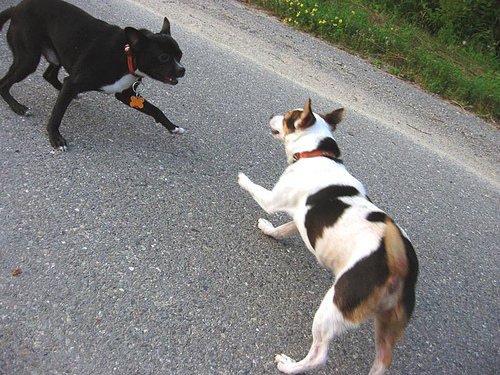

24/07/22 21:18:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [18]:
first_df = classification_df.first() 
img = Image.open(first_df["image_path"])
print(f"\nCaption: {first_df["caption"]}, \nClassification: {first_df["classification"]}")
img